In [2]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = CIFAR10('data', train=True, download=True, transform=transform)
test_dataset = CIFAR10('data', train=False, download=True, transform=transform)

train_dataset, dev_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.80), int(len(train_dataset) * 0.2)])

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


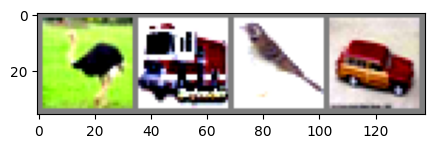

 bird truck  bird   car


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to display images with labels
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Create a DataLoader
data_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Get a batch of training data
data_iter = iter(data_loader)
images, labels = next(data_iter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [3]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
total_dev_size = len(dev_dataset)

classes = 10
input_dim = 3 * 32 * 32  # CIFAR-10 images are 32x32 with 3 color channels

num_clients = 8
rounds = 5
batch_size = 128
epochs_per_client = 3
learning_rate = 2e-2

total_train_size, total_dev_size, total_test_size

(41500, 8500, 10000)

In [4]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

Define Model class

In [5]:
import copy
class FederatedNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, 7)
        self.conv2 = torch.nn.Conv2d(20, 40, 7)
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(2560, 10)
        self.non_linearity = torch.nn.functional.relu
        self.track_layers = {'conv1': self.conv1, 'conv2': self.conv2, 'linear': self.linear}

    def forward(self, x_batch):
        out = self.conv1(x_batch)
        out = self.non_linearity(out)
        out = self.conv2(out)
        out = self.non_linearity(out)
        out = self.maxpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        return out

    def get_track_layers(self):
        return self.track_layers

    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                self.track_layers[layer_name].weight.data *= 0
                self.track_layers[layer_name].bias.data *= 0
                self.track_layers[layer_name].weight.data += parameters_dict[layer_name]['weight']
                self.track_layers[layer_name].bias.data += parameters_dict[layer_name]['bias']

    def get_parameters(self, deep_copy = True):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = {
                'weight': self.track_layers[layer_name].weight.data,
                'bias': self.track_layers[layer_name].bias.data
            }
        if deep_copy:
            params_clone = copy.deepcopy(parameters_dict)
            return params_clone
        else:
            return parameters_dict

    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)

    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history

    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

Define Client class

In [6]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset

    def get_dataset_size(self):
        return len(self.dataset)

    def get_client_id(self):
        return self.client_id
    
    def __difference(self, params1 : dict, params2 : dict):
        diff = {}
        for layer in params1.keys():
            diff[layer] = {}
            for key in params1[layer].keys():
                diff[layer][key] = params1[layer][key] - params2[layer][key]
        return diff

    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.apply_parameters(parameters_dict)
        wt = net.get_parameters(deep_copy=True)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        wt_plus_1 = net.get_parameters(deep_copy=True)
        update = self.__difference(wt, wt_plus_1)
        return update

Setup clients

In [7]:
examples_per_client = total_train_size // num_clients
client_datasets = random_split(train_dataset, [min(i + examples_per_client,
           total_train_size) - i for i in range(0, total_train_size, examples_per_client)])
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

In [8]:
client = clients[0]
global_net = to_device(FederatedNet(), device)
curr_parameters = global_net.get_parameters()
wt, wt_plus_1, update = client.train(curr_parameters)
update

client_0: Loss = 0.4638, Accuracy = 0.8638


'linear'

In [9]:
def diff(wt, wt_plus_1):
    for layer in wt.keys():
        for key in wt[layer].keys():
            print(wt[layer][key] - wt_plus_1[layer][key])

In [10]:
def reconstruct_wt_plus_1(global_params, client_updates):
    wt_plus_1 = {}
    for layer in global_params.keys():
        wt_plus_1[layer] = {}
        for key in global_params[layer].keys():
            wt_plus_1[layer][key] = global_params[layer][key] - client_updates[layer][key]
    return wt_plus_1

Start server

In [11]:
from time import time 
start = time()
global_net = to_device(FederatedNet(), device)
history = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    updates = []
    for client in clients:
        update = client.train(curr_parameters)
        updates.append(update)
    for update in updates:
        client_parameters = reconstruct_wt_plus_1(curr_parameters, update)
        fraction = client.get_dataset_size() / total_train_size
        for layer_name in client_parameters:
            new_parameters[layer_name]['weight'] += fraction * (client_parameters[layer_name]['weight'] + curr_parameters[layer_name]['weight'])
            new_parameters[layer_name]['bias'] += fraction * (client_parameters[layer_name]['bias'] + curr_parameters[layer_name]['bias'])
    global_net.apply_parameters(new_parameters)

    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(dev_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4),
            round(dev_loss, 4), round(dev_acc, 4)))
    history.append((train_loss, dev_loss, dev_acc))

Start Round 1 ...
client_0: Loss = 0.4534, Accuracy = 0.8651
client_1: Loss = 0.4654, Accuracy = 0.858
client_2: Loss = 0.4665, Accuracy = 0.8612
client_3: Loss = 0.4495, Accuracy = 0.8641
client_4: Loss = 0.4602, Accuracy = 0.8619
client_5: Loss = 0.4527, Accuracy = 0.8697
client_6: Loss = 0.4655, Accuracy = 0.8585
client_7: Loss = 0.435, Accuracy = 0.8711
After round 1, train_loss = 0.4397, dev_loss = 0.4495, dev_acc = 0.8771

Start Round 2 ...
client_0: Loss = 0.2419, Accuracy = 0.9342
client_1: Loss = 0.2498, Accuracy = 0.9252
client_2: Loss = 0.2401, Accuracy = 0.932
client_3: Loss = 0.2308, Accuracy = 0.9297
client_4: Loss = 0.2344, Accuracy = 0.9307


In [ ]:
print('time took:', time() - start)

time took: 1252.1028289794922


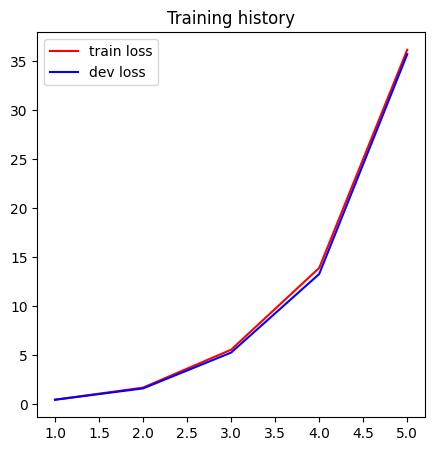

In [ ]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='dev loss')
plt.legend()
plt.title('Training history')
plt.show()

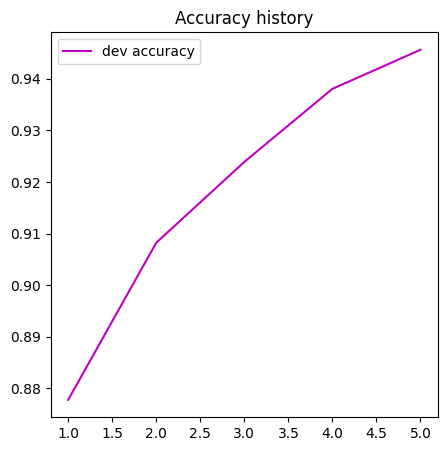

In [ ]:
dev_accs = [history[i][2] for i in range(len(history))]
# Plot accuracies
plt.plot([i + 1 for i in range(len(history))], dev_accs, color='m', label='dev accuracy')
plt.legend()
plt.title('Accuracy history')
plt.show()

In [ ]:
dev_accs

[0.8777698278427124,
 0.9082208871841431,
 0.9238902926445007,
 0.9380504488945007,
 0.9456232190132141]